#### 1. Refer to this section for a description of the problem

__[Kaggle](https://www.kaggle.com/competitions/titanic/data)__ platform provides two datasets (_train.csv_, _test.csv_) containing detailed information about Titanic passengers, such as :
- A unique identifier for each passenger (_PassengerId_) ;
- The class of service in which the passenger traveled (_Pclass_) ;
- The passenger's full name (_Name_) ;
- The gender of the passenger (_Sex_) ;
- The age of the passenger (_Age_) ;
- The number of siblings or spouses accompanying the passenger on the ship (_SibSp_) ;
- The number of parents or children accompanying the passenger on the ship (_Parch_) ;
- The ticket number assigned to the passenger (_Ticket_) ;
- The fare paid by the passenger (_Fare_) ;
- The cabin number assigned to the passenger (_Cabin_) ;
- The port from which the passenger embarked (_Embarked_) ;
- The survival status of the passenger post-collision (_Survived_), which is available only in the _train.csv_ dataset.

Based on the data and relationships identified in the _train.csv_ file, we aim to predict the survival status of passengers listed in the _test.csv_ file following the shipwreck.

#### 2. Import required libraries

In [69]:
import gc, pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.stats import kruskal, chi2_contingency
from pathlib import Path

#### 3. Set up correct path

In [70]:
windowspath__scripts = Path().resolve()
windowspath__data = windowspath__scripts.parent / "data"

#### 4. Import train.csv and test.csv files

In [71]:
df__train = pd.read_csv(filepath_or_buffer=windowspath__data / "train" / "train.csv", dtype=str)
df__test = pd.read_csv(filepath_or_buffer=windowspath__data / "test" / "test.csv", dtype=str)

In [72]:
df__train.sample(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
559,560,1,3,"de Messemaeker, Mrs. Guillaume Joseph (Emma)",female,36,1,0,345572,17.4,NaN,S
184,185,1,3,"Kink-Heilmann, Miss. Luise Gretchen",female,4,0,2,315153,22.025,NaN,S
477,478,0,3,"Braund, Mr. Lewis Richard",male,29,1,0,3460,7.0458,NaN,S


In [73]:
df__test.sample(n=3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
200,1092,3,"Murphy, Miss. Nora",female,NaN,0,0,36568,15.5,NaN,Q
154,1046,3,"Asplund, Master. Filip Oscar",male,13,4,2,347077,31.3875,NaN,S
324,1216,1,"Kreuchen, Miss. Emilie",female,39,0,0,24160,211.3375,NaN,S


#### 5. Feature engineering

In [74]:
# Define an unified view of df__train and df__test
df__titanic = pd.concat([df__train.copy(deep=True).drop(columns=["Survived"]), df__test.copy(deep=True)], ignore_index=True)

# Tip: samples of df__train and df__test are identified by their PassengerId

df__titanic.sample(n=3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
839,840,1,"Marechal, Mr. Pierre",male,NaN,0,0,11774,29.7,C47,C
32,33,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.75,NaN,Q
323,324,2,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...",female,22,1,1,248738,29,NaN,S


##### *5.1. PClass, Ticket, Cabin*

In [75]:
# Remove "Ticket" and "Cabin" since their information can be seen as summarized in "PClass"
df__titanic.drop(columns=["Ticket", "Cabin"], inplace=True)

In [76]:
# Are there missing values in "Pclass" ?
df__titanic[["Pclass"]].isnull().sum()

Pclass    0
dtype: int64

In [77]:
# Rewrite "PClass" feature as "BoardingClass"
# first class is the most privileged, second class is moderately privileged, and third class is the least privileged. 
dict__pclass = {"1": "most privileged", "2": "moderately privileged", "3": "least privileged"}  
df__titanic["BoardingClass"] = df__titanic["Pclass"].map(dict__pclass)

# Cleanup
del df__titanic["Pclass"], dict__pclass

<Axes: title={'center': 'BoardingClass count distribution'}, xlabel='BoardingClass'>

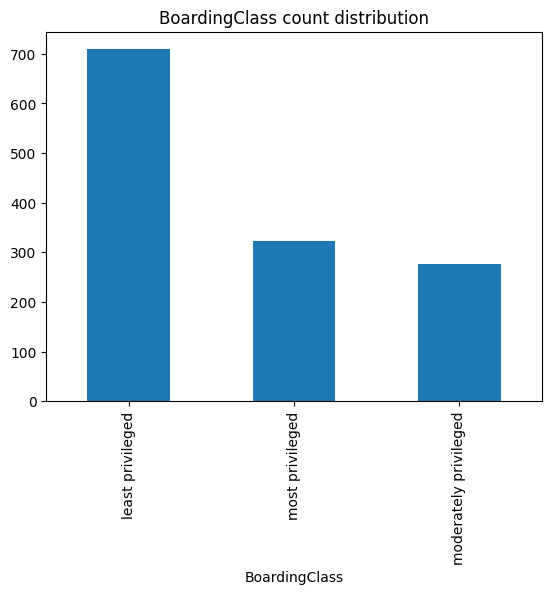

In [78]:
# Take a look at "BoardingClass"
df__titanic["BoardingClass"].value_counts().plot(kind="bar", title="BoardingClass count distribution")

<div style="background-color: green; padding: 10px;">
Half of the passengers on the ship are least privileged people.
</div>

In [79]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Name,Sex,Age,SibSp,Parch,Fare,Embarked,BoardingClass
81,82,"Sheerlinck, Mr. Jan Baptist",male,29,0,0,9.5,S,least privileged
511,512,"Webber, Mr. James",male,NaN,0,0,8.05,S,least privileged
79,80,"Dowdell, Miss. Elizabeth",female,30,0,0,12.475,S,least privileged


##### *5.2. Name, Sex, Age*

In [80]:
# Are there missing values in "Sex" ?
df__titanic[["Sex"]].isnull().sum()

Sex    0
dtype: int64

In [81]:
# Lowercase "Name" values, and remove periods
df__titanic["Name"] = df__titanic["Name"].apply(lambda x: x.lower().replace(".", ""))

<div style="background-color: green; padding: 10px;">

Research on early 20th-century naming conventions provides insights into titles incorporated in names, which often indicated age or marital status :

- Adult titles : "mr", "mrs", "sir", "rev", "capt", "dr", "col", "major", "ms", "mme", "countess", "don", "jonkheer"

- Youth titles : "master", "miss"

- Ambiguous titles : "mlle" (used for both young girls and unmarried women)

Aldulthood for men was 21; whereas for women, it was 18 or 21.

</div>

In [82]:
# Extract a "Title" column from "Name" column

# Define a list of all possible titles
list__adulttitles = ["mr", "mrs", "sir", "rev", "capt", "dr", "col", "major", "ms", "mme", "countess", "don", "jonkheer"]
list__youngtitles = ["master", "miss"]
list__ambiguoustitles = ["mlle"]
list__alltitles = list__adulttitles + list__youngtitles + list__ambiguoustitles

# An example of function to extract title
def function__title(str__name: str) -> str:
    """
    Input:
    str__name : a string (real name and title)
    Output:
    str__title : a string (title)
    """
    for str__title in list__alltitles:
        if str__title in str__name:
            return str__title

# Apply function__title on "Name" column
df__titanic["Title"] = df__titanic["Name"].apply(lambda x: function__title(x))

# Cleanup
del df__titanic["Name"], list__alltitles

<Axes: title={'center': 'Title count distribution'}, xlabel='Title'>

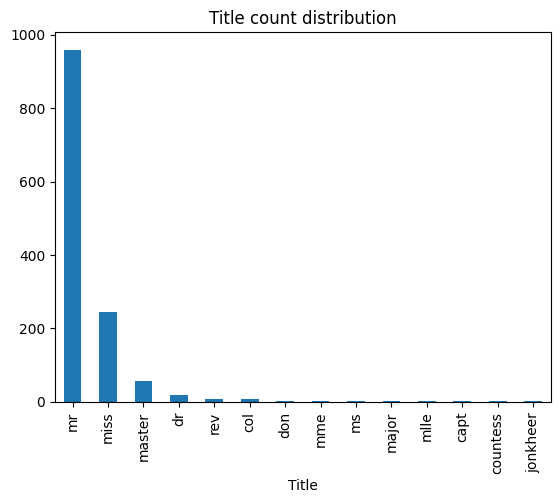

In [83]:
# Take a look at "Title"
df__titanic["Title"].value_counts().plot(kind="bar", title="Title count distribution")

<div style="background-color: green; padding: 10px;">
More than half of the passengers on the ship are adult men.
</div>

In [84]:
# Are there missing values in "Age" ?
df__titanic[["Age"]].isnull().sum()

Age    263
dtype: int64

In [85]:
# Set "Age" column data type to decimal number
df__titanic["Age"] = df__titanic["Age"].astype(float)

<div style="background-color: green; padding: 10px;">
Decimals age values can be challenging to interpret. Some of the folks who worked on Titanic problem, explained that these decimals arise when ages are estimated.
</div>

In [86]:
# Analyze the proportion of samples with missing age values
print(f"Of the {len(df__titanic)} samples, {(100*df__titanic["Age"].isnull().sum() / len(df__titanic)):.2f}% have missing age values.")

Of the 1309 samples, 20.09% have missing age values.


In [87]:
# Define a new column "AgeCategory" based on "Title" and "Age"

# An example of function to categorize age
def function__agecategory(str__title: str, float__age: float, float__adulthood = 21.0) -> str:
    """
    Input:
    str__title : a string (title)
    float__age : a decimal number (age)
    float__adulthood : a decimal number (age value to know if adulthood is reached or not)
    Output:
    str__title : a string (title)
    """
    # Test if age value is different of NA
    if float__age != np.nan:
        # Compare its value to adulthood threshold
        if float__age < float__adulthood:
            return "young"
        else: return "adult"
    
    # Test if age value is NA
    if float__age == np.nan:
        # Use title to know if adulthood is reached
        if str__title in list__adulttitles:
            return "adult"
        if str__title in list__youngtitles:
            return "young"
        if str__title in list__ambiguoustitles:
            return "young/adult"

# Apply function__agecategory
df__titanic["AgeCategory"] = df__titanic.apply(lambda row: function__agecategory(str__title=row["Title"], float__age=row["Age"]), axis=1)

# Cleanup
del df__titanic["Age"], df__titanic["Title"], list__adulttitles, list__youngtitles, list__ambiguoustitles

<Axes: title={'center': 'AgeCategory count distribution'}, xlabel='AgeCategory'>

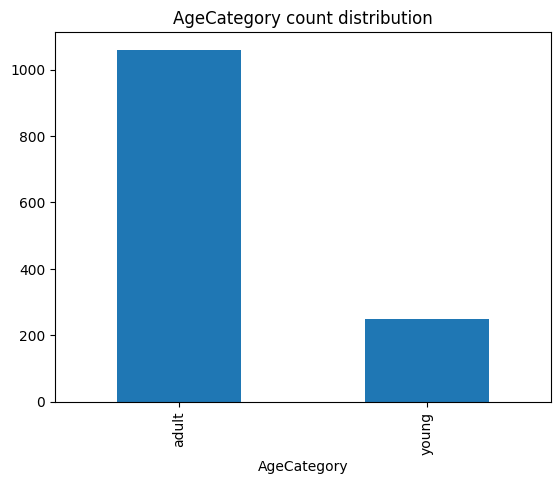

In [88]:
# Take a look at "AgeCategory"
df__titanic["AgeCategory"].value_counts().plot(kind="bar", title="AgeCategory count distribution")

<div style="background-color: green; padding: 10px;">
Since "AgeCategory" is a result of combining "Title" and "Age" in order to impute "Age" missing values, it's normal that more than half of the passengers are adults (especially adult men).
</div>

In [89]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Sex,SibSp,Parch,Fare,Embarked,BoardingClass,AgeCategory
265,266,male,0,0,10.5,S,moderately privileged,adult
152,153,male,0,0,8.05,S,least privileged,adult
981,982,female,1,0,13.9,S,least privileged,adult


##### *5.3. SibSp, ParCh, Fare*

In [90]:
# Are there missing values in "SibSp"?
df__titanic[["SibSp"]].isnull().sum()

SibSp    0
dtype: int64

In [91]:
# Are there missing values in "Parch"?
df__titanic[["Parch"]].isnull().sum()

Parch    0
dtype: int64

In [92]:
# Set "SibSp" and "Parch" data type to integer
df__titanic[["SibSp","Parch"]] = df__titanic[["SibSp","Parch"]].astype(int)

# Create "FamilySize" by incrementing of 1 the sum of "SibSp" and "Parch" 
df__titanic["FamilySize"] = df__titanic[["SibSp","Parch"]].sum(axis=1) + 1

# Cleanup
df__titanic.drop(columns=["SibSp","Parch"], inplace=True)

<Axes: title={'center': 'FamilySize count distribution'}, xlabel='FamilySize'>

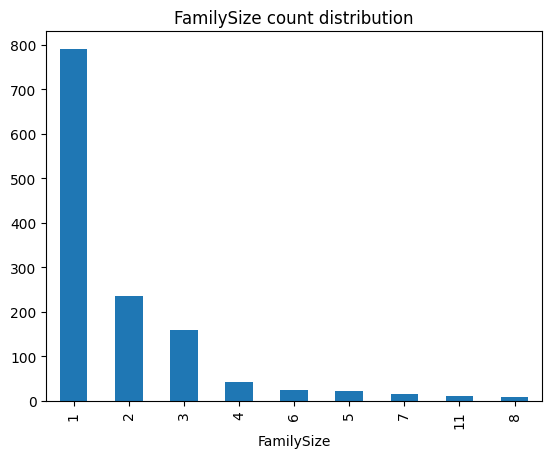

In [93]:
# Take a look at "FamilySize"
df__titanic["FamilySize"].value_counts().plot(kind="bar", title="FamilySize count distribution")

<div style="background-color: green; padding: 10px;">

More than half of the passengers on the ship were alone.

We decide to transform "FamilySize" into a qualitative variable with two modalities : "alone", ant "not alone".

</div>

In [94]:
# Transform "FamilySize" into a qualitative variable with two modalities : "alone", ant "not alone"
df__titanic["FamilySize"] = df__titanic["FamilySize"].apply(lambda x: "alone" if x == 1 else "not alone")

In [95]:
# Are there missing values in "Fare" ?
df__titanic[["Fare"]].isnull().sum()

# Only one passenger "Fare" is missing.

Fare    1
dtype: int64

<Axes: title={'center': 'Fare distribution'}, ylabel='Frequency'>

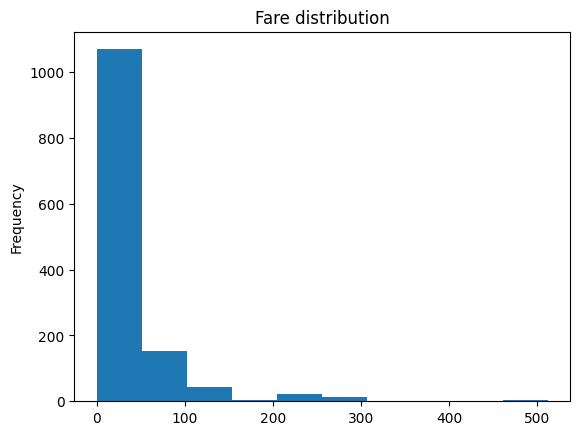

In [96]:
# Set "Fare" data type to float
df__titanic["Fare"] = df__titanic["Fare"].astype(float)

# Take a look at "Fare"
df__titanic["Fare"].plot(kind="hist", title="Fare distribution")

<div style="background-color: green; padding: 10px;">
"Fare" distribution is right-skewed, which is normal since most of the people were least priviliged (3rd class tickets).
Let's dive further.
</div>

In [97]:
# Cross "Fare" values with "BoardingClass" modalities
df__titanic[["Fare", "BoardingClass"]].groupby(["BoardingClass"], observed=False).describe()

Fare                                               \
                       count       mean        std  min      25%      50%   
BoardingClass                                                               
least privileged       708.0  13.302889  11.494358  0.0   7.7500   8.0500   
moderately privileged  277.0  21.179196  13.607122  0.0  13.0000  15.0458   
most privileged        323.0  87.508992  80.447178  0.0  30.6958  60.0000   

                                           
                            75%       max  
BoardingClass                              
least privileged        15.2458   69.5500  
moderately privileged   26.0000   73.5000  
most privileged        107.6625  512.3292

<div style="background-color: green; padding: 10px;">
Tickets' Fare seems to depend on "BoardingClass" as we thought after "Fare" distribution analysis. Let's confirm statistically the correlation between these two features.
</div>

In [98]:
# Do a Kruskall-Wallis test between "Fare" and "BoardingClass" as a proof of high correlation between these two features

# Do not consider the passenger with missing "Fare"
df__table = df__titanic[["Fare", "BoardingClass"]].copy(deep=True).dropna()

# Perform a Kruskall-Wallis test with a 95% level of confidence
kruskal(*df__table.groupby(["BoardingClass"], observed=False)["Fare"].apply(list))

KruskalResult(statistic=np.float64(675.6437116957771), pvalue=np.float64(1.9312217278120738e-147))

<div style="background-color: green; padding: 10px;">

Based on 1308 passengers with no missing "Fare" value :
- The p-value computed from a Kruskal-Wallis test with 95% level of confidence between "Fare" and "BoardingClass" is up to 3.24e-72 ;
- The p-value computed is much lesser than 0.05, and we conclude that there's statistically a correlation between these two features under a risk level of 5%.

Since "Fare" is the one with one missing value out of 1309 passengers, we'll remove it and keep only "BoardingClass".
</div>

In [99]:
# Cleanup
del df__table, df__titanic["Fare"]

In [100]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Sex,Embarked,BoardingClass,AgeCategory,FamilySize
1278,1279,male,S,moderately privileged,adult,alone
376,377,female,S,least privileged,adult,alone
716,717,female,C,most privileged,adult,alone


##### *5.4. Embarked*

In [101]:
# Are there missing values in "Embarked" ?
df__titanic[["Embarked"]].isnull().sum()

# Two passengers' embarkation towns are missing.

Embarked    2
dtype: int64

<Axes: title={'center': 'Embarked count distribution'}, xlabel='Embarked'>

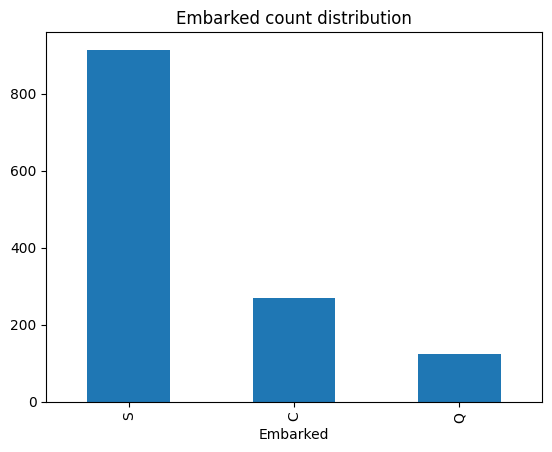

In [102]:
# Take a look at "Embarked"
df__titanic["Embarked"].value_counts().plot(kind="bar", title="Embarked count distribution")

<div style="background-color: green; padding: 10px;">
More than half of the passengers on the ship were and/or embarked from Southampton (S).
</div>

In [103]:
# We choose to impute the most present modality to these two passengers with missing embarkation towns
df__titanic["Embarked"] = df__titanic["Embarked"].fillna(value=df__titanic["Embarked"].mode()[0], inplace=False)

In [104]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Sex,Embarked,BoardingClass,AgeCategory,FamilySize
182,183,male,S,least privileged,young,not alone
905,906,female,S,most privileged,adult,not alone
271,272,male,S,least privileged,adult,alone


##### *5.5. Retrieve engineered versions of df__train and df__test*

In [105]:
# Get engineered version of df__train
df__engtrain = df__train[["PassengerId", "Survived"]].merge(right=df__titanic, on=["PassengerId"], how="left")

# Make sure that "Survived" data type is set to integer
df__engtrain["Survived"] = df__engtrain["Survived"].astype(int)

# Get engineered version of df__test
df__engtest = df__test[["PassengerId"]].merge(right=df__titanic, on=["PassengerId"], how="left")

# Cleanup
del df__titanic, df__test, df__train

In [106]:
# Make sure joins and feature engineering worked well so no missing values are present in df__engtrain
df__engtrain.isnull().sum()

PassengerId      0
Survived         0
Sex              0
Embarked         0
BoardingClass    0
AgeCategory      0
FamilySize       0
dtype: int64

In [107]:
# Make sure joins and feature engineering worked well so no missing values are present in df__engtest
df__engtest.isnull().sum()

PassengerId      0
Sex              0
Embarked         0
BoardingClass    0
AgeCategory      0
FamilySize       0
dtype: int64

#### 6. Association between covariates and the target Survived

##### *6.1. Sex and Survived*

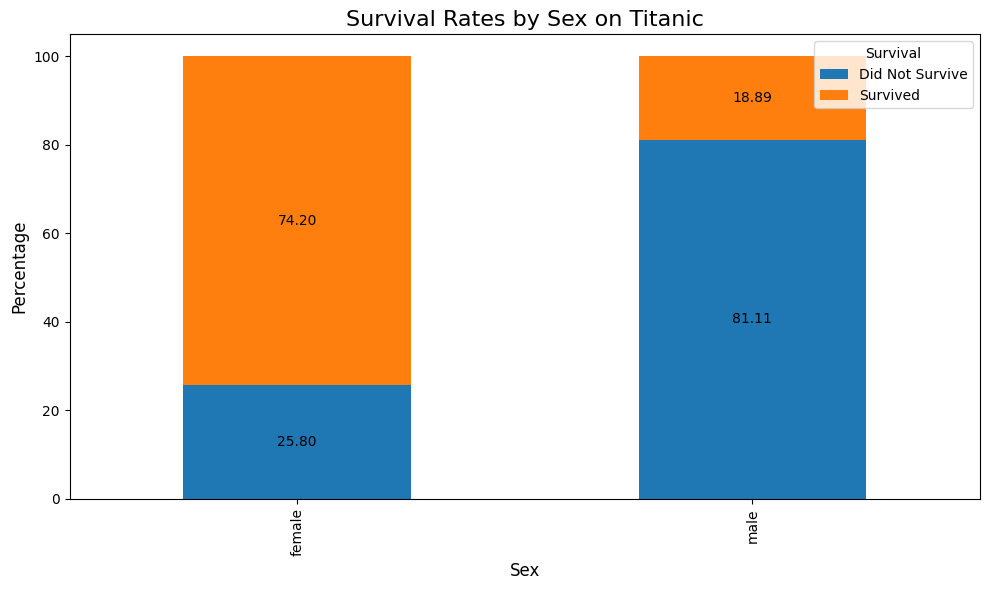

In [108]:
# Create a cross-tab between "Sex" and "Survived"
df__table = 100 * pd.crosstab(df__engtrain["Sex"], df__engtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax_object = df__table.plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the chart
plt.title('Survival Rates by Sex on Titanic', fontsize=16)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(['Did Not Survive', 'Survived'], title='Survival', loc='upper right')

# Add value labels on the bars, rounded to two decimal places
for barcontainer_object in ax_object.containers:
    ax_object.bar_label(barcontainer_object, label_type='center', fmt='%.2f')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [109]:
# Cleanup
del df__table, ax_object, barcontainer_object

In [110]:
# Perform a Chi-Square test (risk level of 5%) between "Sex" and "Survived"
chi2_contingency(pd.crosstab(df__engtrain["Sex"], df__engtrain["Survived"]))

Chi2ContingencyResult(statistic=np.float64(260.71702016732104), pvalue=np.float64(1.1973570627755645e-58), dof=1, expected_freq=array([[193.47474747, 120.52525253],
       [355.52525253, 221.47474747]]))

In [111]:
# Calculate Cramer's V for effect size : strength of the association between "Sex" and "Survived"
df__table = pd.crosstab(df__engtrain["Sex"], df__engtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.5409359434469282)

In [112]:
# Cleanup
del df__table

<div style="background-color: green; padding: 10px;">

- The p-value of the Chi-Square test between "Sex" and "Survived" is up to 1.2e-58 (lesser than 0.05).
- The strength of the association between "Sex" and "Survived" is up to 54%.
- Under a risk level of 5%, the survival rate of a passenger on the Titanic is statistically linked to him being a man/woman; women being those with the best survival rate.
- We will order "Sex" modalities as "female" > "male" since women have a better survival rate compared to men.

</div>

In [113]:
# Order "Sex" modalities
df__engtrain["Sex"] = pd.Categorical(df__engtrain["Sex"], categories=["male", "female"], ordered=True)

##### *6.2. Embarked and Survived*

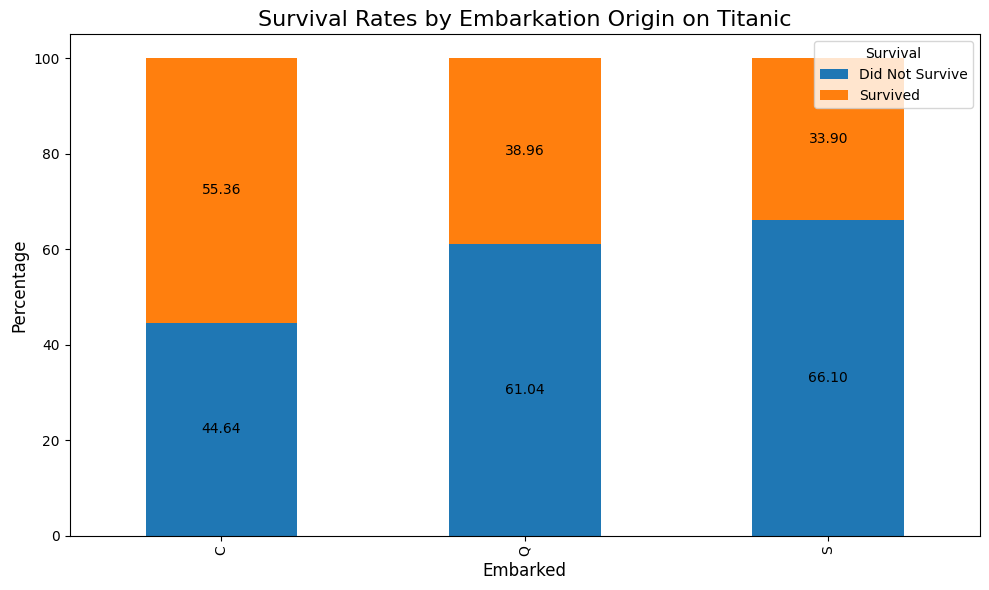

In [114]:
# Create a cross-tab between "Embarked" and "Survived"
df__table = 100 * pd.crosstab(df__engtrain["Embarked"], df__engtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax_object = df__table.plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the chart
plt.title('Survival Rates by Embarkation Origin on Titanic', fontsize=16)
plt.xlabel('Embarked', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(['Did Not Survive', 'Survived'], title='Survival', loc='upper right')

# Add value labels on the bars, rounded to two decimal places
for barcontainer_object in ax_object.containers:
    ax_object.bar_label(barcontainer_object, label_type='center', fmt='%.2f')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [115]:
# Cleanup
del df__table, ax_object, barcontainer_object

In [116]:
# Perform a Chi-Square test (risk level of 5%) between "Embarked" and "Survived"
chi2_contingency(pd.crosstab(df__engtrain["Embarked"], df__engtrain["Survived"]))

Chi2ContingencyResult(statistic=np.float64(25.964452881874784), pvalue=np.float64(2.3008626481449577e-06), dof=2, expected_freq=array([[103.51515152,  64.48484848],
       [ 47.44444444,  29.55555556],
       [398.04040404, 247.95959596]]))

In [117]:
# Calculate Cramer's V for effect size : strength of the association between "Embarked" and "Survived"
df__table = pd.crosstab(df__engtrain["Embarked"], df__engtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.17070676639164276)

In [118]:
# Cleanup
del df__table

<div style="background-color: green; padding: 10px;">

- The p-value of the Chi-Square test between "Embarked" and "Survived" is up to 2.3e-06 (lesser than 0.05).
- The strength of the association between "Embarked" and "Survived" is up to 17%.
- Under a risk level of 5%, the survival rate of a passenger on the Titanic is statistically linked to its embarkation point; Cherbourg being the one with the best survival rate, Queenstown and Southampton having the lowest survival rates.
- We decide to regroup Queenstown and Southampton together as an unique modality "S/Q" since they present similar survival rates.
- We will order "Embarked" modalities as "C" > "S/Q" since Cherbourg has the best survival rate.

</div>

In [119]:
# Regroup "S" and "Q" as an unique modality "S/Q"
df__engtrain["Embarked"] = df__engtrain["Embarked"].apply(lambda x: "S/Q" if x == "S" or x =="Q" else x)

# Order "Embarked" modalities
df__engtrain["Embarked"] = pd.Categorical(df__engtrain["Embarked"], categories=["S/Q", "C"], ordered=True) 

In [ ]:
# Don't forget to apply the same transformation on the test data
df__engtest["Embarked"] = df__engtest["Embarked"].apply(lambda x: "S/Q" if x == "S" or x =="Q" else x)
df__engtest["Embarked"] = pd.Categorical(df__engtest["Embarked"], categories=["S/Q", "C"], ordered=True) 

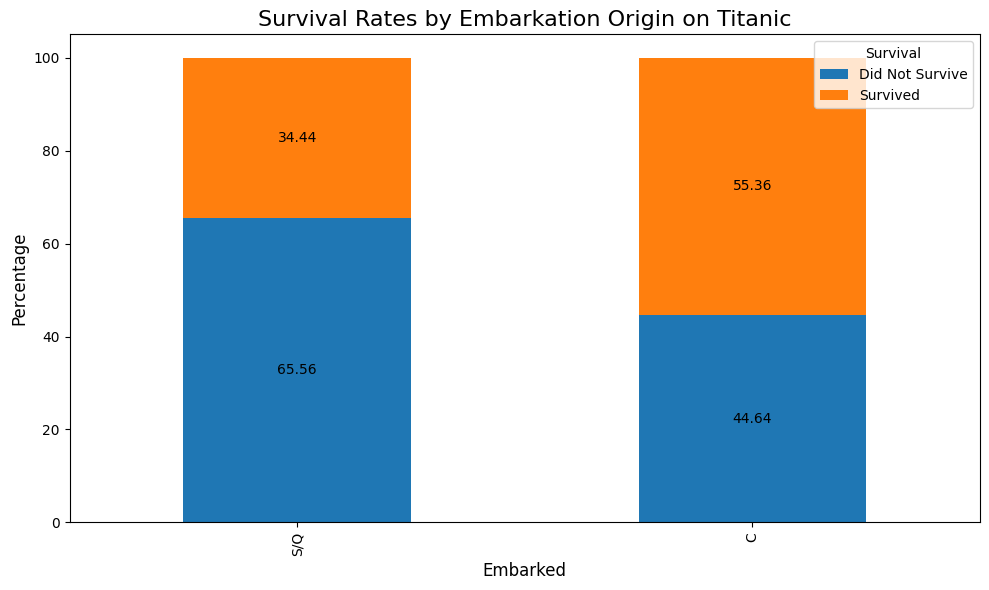

In [120]:
# Perform the new visualization of survival rate by embarkation point

# Create a cross-tab between "Embarked" and "Survived"
df__table = 100 * pd.crosstab(df__engtrain["Embarked"], df__engtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax_object = df__table.plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the chart
plt.title('Survival Rates by Embarkation Origin on Titanic', fontsize=16)
plt.xlabel('Embarked', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(['Did Not Survive', 'Survived'], title='Survival', loc='upper right')

# Add value labels on the bars, rounded to two decimal places
for barcontainer_object in ax_object.containers:
    ax_object.bar_label(barcontainer_object, label_type='center', fmt='%.2f')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [121]:
# Cleanup
del df__table, ax_object, barcontainer_object

In [122]:
# Recalculate Cramer's V for effect size : strength of the association between "Embarked" and "Survived" 
# (Check if its value has increased or isn't too low compared to before)
df__table = pd.crosstab(df__engtrain["Embarked"], df__engtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.1652904130300282)

In [123]:
# Cleanup
del df__table

##### *6.3. BoardingClass and Survived*

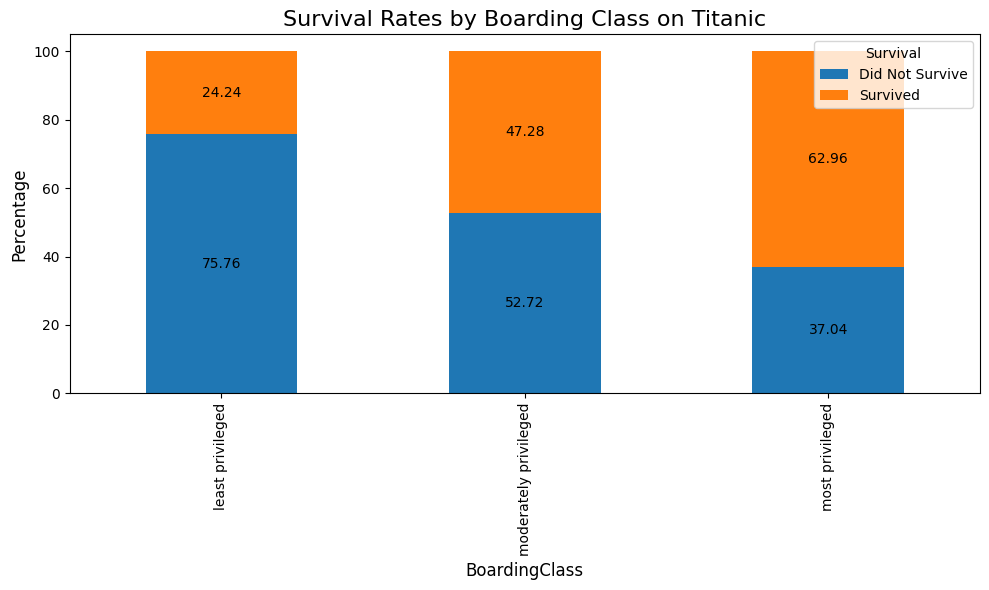

In [124]:
# Create a cross-tab between "BoardingClass" and "Survived"
df__table = 100 * pd.crosstab(df__engtrain["BoardingClass"], df__engtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax_object = df__table.plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the chart
plt.title('Survival Rates by Boarding Class on Titanic', fontsize=16)
plt.xlabel('BoardingClass', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(['Did Not Survive', 'Survived'], title='Survival', loc='upper right')

# Add value labels on the bars, rounded to two decimal places
for barcontainer_object in ax_object.containers:
    ax_object.bar_label(barcontainer_object, label_type='center', fmt='%.2f')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [125]:
# Cleanup
del df__table, ax_object, barcontainer_object

In [126]:
# Perform a Chi-Square test (risk level of 5%) between "BoardingClass" and "Survived"
chi2_contingency(pd.crosstab(df__engtrain["BoardingClass"], df__engtrain["Survived"]))

Chi2ContingencyResult(statistic=np.float64(102.88898875696057), pvalue=np.float64(4.5492517112987275e-23), dof=2, expected_freq=array([[302.53535354, 188.46464646],
       [113.37373737,  70.62626263],
       [133.09090909,  82.90909091]]))

In [127]:
# Calculate Cramer's V for effect size : strength of the association between "BoardingClass" and "Survived"
df__table = pd.crosstab(df__engtrain["BoardingClass"], df__engtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.33981738800531175)

In [128]:
# Cleanup
del df__table

<div style="background-color: green; padding: 10px;">

- The p-value of the Chi-Square test between "BoardingClass" and "Survived" is up to 5e-23 (lesser than 0.05).
- The strength of the association between "BoardingClass" and "Survived" is up to 34%.
- Under a risk level of 5%, the survival rate of a passenger on the Titanic is statistically linked to its boarding class; the most privileged class is the one with the best survival rate, followed by the moderately privileged and finally the less privileged. 
- From one boarding class to another, the survival rate drops/increases at least by 15%.
- We will order "BoardingClass" modalities as "most privileged" > "moderately privileged" > "least privileged".

</div>

In [129]:
# Order "BoardingClass" modalities
df__engtrain["BoardingClass"] = pd.Categorical(df__engtrain["BoardingClass"], categories=["least privileged", "moderately privileged", "most privileged"], ordered=True) 

In [ ]:
# Don't forget to apply the same transformation on the test data
df__engtest["BoardingClass"] = pd.Categorical(df__engtest["BoardingClass"], categories=["least privileged", "moderately privileged", "most privileged"], ordered=True)

##### *6.4. AgeCategory and Survived*

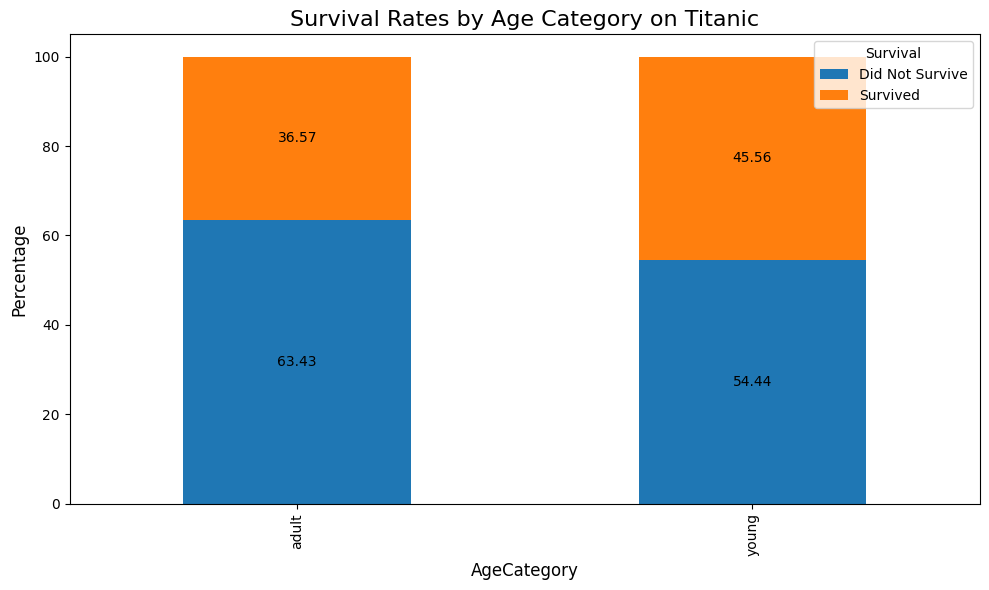

In [130]:
# Create a cross-tab between "AgeCategory" and "Survived"
df__table = 100 * pd.crosstab(df__engtrain["AgeCategory"], df__engtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax_object = df__table.plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the chart
plt.title('Survival Rates by Age Category on Titanic', fontsize=16)
plt.xlabel('AgeCategory', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(['Did Not Survive', 'Survived'], title='Survival', loc='upper right')

# Add value labels on the bars, rounded to two decimal places
for barcontainer_object in ax_object.containers:
    ax_object.bar_label(barcontainer_object, label_type='center', fmt='%.2f')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [131]:
# Cleanup
del df__table, ax_object, barcontainer_object

In [132]:
# Perform a Chi-Square test (risk level of 5%) between "AgeCategory" and "Survived"
chi2_contingency(pd.crosstab(df__engtrain["AgeCategory"], df__engtrain["Survived"]))

Chi2ContingencyResult(statistic=np.float64(4.532861903539718), pvalue=np.float64(0.03324996842582618), dof=1, expected_freq=array([[438.09090909, 272.90909091],
       [110.90909091,  69.09090909]]))

In [133]:
# Calculate Cramer's V for effect size : strength of the association between "AgeCategory" and "Survived"
df__table = pd.crosstab(df__engtrain["AgeCategory"], df__engtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.07132592163531087)

In [134]:
# Cleanup
del df__table

<div style="background-color: green; padding: 10px;">

- The p-value of the Chi-Square test between "AgeCategory" and "Survived" is up to 0.03 (just is little lesser than 0.05).
- The strength of the association between "AgeCategory" and "Survived" is really low (only 7.1%) compared to the previous covariates.
- "AgeCategory" has a limited explanatory power regarding "Survived".

</div>

##### *6.5. FamilySize and Survived*

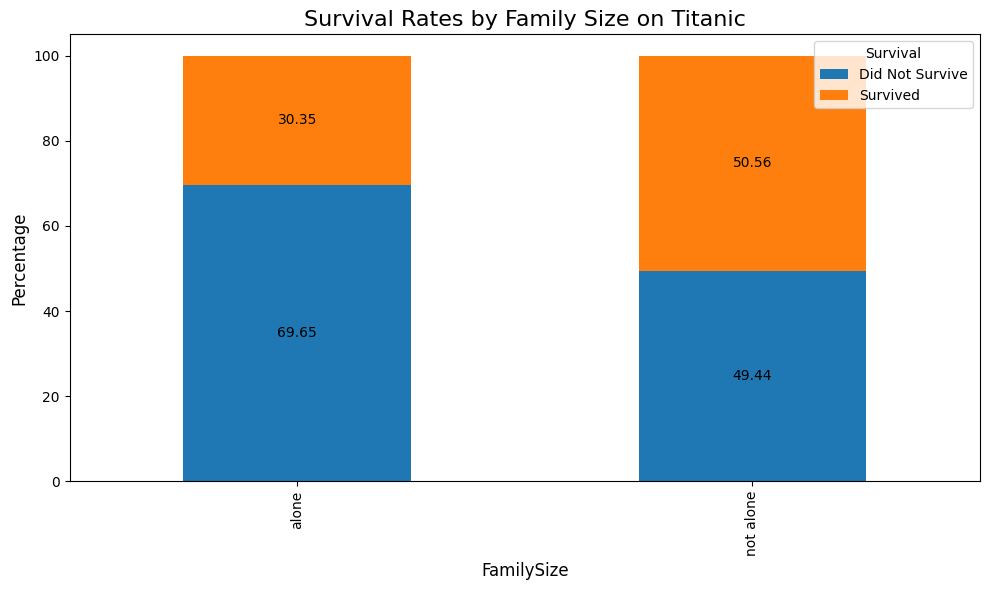

In [137]:
# Create a cross-tab between "FamilySize" and "Survived"
df__table = 100 * pd.crosstab(df__engtrain["FamilySize"], df__engtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax_object = df__table.plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the chart
plt.title('Survival Rates by Family Size on Titanic', fontsize=16)
plt.xlabel('FamilySize', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(['Did Not Survive', 'Survived'], title='Survival', loc='upper right')

# Add value labels on the bars, rounded to two decimal places
for barcontainer_object in ax_object.containers:
    ax_object.bar_label(barcontainer_object, label_type='center', fmt='%.2f')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [138]:
# Cleanup
del df__table, ax_object, barcontainer_object

In [139]:
# Perform a Chi-Square test (risk level of 5%) between "FamilySize" and "Survived"
chi2_contingency(pd.crosstab(df__engtrain["FamilySize"], df__engtrain["Survived"]))

Chi2ContingencyResult(statistic=np.float64(36.00051446773864), pvalue=np.float64(1.9726543846517183e-09), dof=1, expected_freq=array([[330.87878788, 206.12121212],
       [218.12121212, 135.87878788]]))

In [140]:
# Calculate Cramer's V for effect size : strength of the association between "FamilySize" and "Survived"
df__table = pd.crosstab(df__engtrain["FamilySize"], df__engtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.20100899932318902)

In [141]:
# Cleanup
del df__table

<div style="background-color: green; padding: 10px;">

- The p-value of the Chi-Square test between "FamilySize" and "Survived" is up to 2e-09 (lesser than 0.05).
- The strength of the association between "FamilySize" and "Survived" is up to 20%.
- Under a risk level of 5%, the survival rate of a passenger on the Titanic is statistically linked to his family size; those not alone being the ones with the best survival rate.
- We will order "FamilySize" modalities as "not alone" > "alone" since those not alone have the best survival rate.

</div>

In [ ]:
# Order "FamilySize" modalities
df__engtrain["FamilySize"] = pd.Categorical(df__engtrain["FamilySize"], categories=["not alone", "alone"], ordered=True) 

In [ ]:
# Don't forget to apply the same transformation on the test data
df__engtest["FamilySize"] = pd.Categorical(df__engtest["FamilySize"], categories=["not alone", "alone"], ordered=True)

In [135]:
df__engtrain

,PassengerId,Survived,Sex,Embarked,BoardingClass,AgeCategory,FamilySize
0,1,0,male,S/Q,least privileged,adult,not alone
1,2,1,female,C,most privileged,adult,not alone
2,3,1,female,S/Q,least privileged,adult,alone
3,4,1,female,S/Q,most privileged,adult,not alone
4,5,0,male,S/Q,least privileged,adult,alone
...,...,...,...,...,...,...,...
886,887,0,male,S/Q,moderately privileged,adult,alone
887,888,1,female,S/Q,most privileged,young,alone
888,889,0,female,S/Q,least privileged,adult,not alone
889,890,1,male,C,most privileged,adult,alone


#### 7. Model Survived feature

In [136]:
# %reset -f